## Conifuration

In [1]:
#import the lib for contrastive learning framework
!pip install lightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 458 kB 10.1 MB/s 
     |████████████████████████████████| 585 kB 33.5 MB/s 
     |████████████████████████████████| 151 kB 17.4 MB/s 
     |████████████████████████████████| 117 kB 38.8 MB/s 
     |████████████████████████████████| 79 kB 3.9 MB/s 
     |████████████████████████████████| 596 kB 40.2 MB/s 
     |████████████████████████████████| 140 kB 43.2 MB/s 
     |████████████████████████████████| 419 kB 45.4 MB/s 
     |████████████████████████████████| 1.1 MB 45.3 MB/s 
     |████████████████████████████████| 144 kB 52.9 MB/s 
     |████████████████████████████████| 271 kB 60.4 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=cd4f3b5a75c27e883f9984bda1f85163e4dec607928149a76f36bc7b5c152d2e
  Stored in directory: /ro

In [2]:
import lightly
from lightly.models.modules.heads import SimSiamPredictionHead
from lightly.models.modules.heads import SimSiamProjectionHead

from lightly.data import LightlyDataset
from lightly.data import ImageCollateFunction
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import BarlowTwinsLoss

from lightly.data import LightlyDataset
from lightly.data import SimCLRCollateFunction
from lightly.loss import NTXentLoss
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimCLRProjectionHead

In [3]:
import math
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from datetime import datetime

from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot
import seaborn as sns

from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import silhouette_score
from sklearn import mixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering

import tensorboard
from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter

import matplotlib 
import matplotlib.pyplot as plt
#import plotly.express as px

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.utils import shuffle

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics.pairwise import cosine_similarity

import random
from torch.nn.modules.loss import MSELoss
from sklearn.neighbors import KDTree
#from kmodes.kprototypes import KPrototypes

from scipy.io.arff import loadarff
from sklearn.preprocessing import MinMaxScaler 
from sklearn.datasets import make_classification

## Load Dataset Zelnik and Check Clustering Result with the Baseline Method Kmeans

In [5]:
# set the path to the dataset
path_to_data = '/content/drive/MyDrive/Colab_Notebooks/zelnik5.arff'

In [6]:
raw = loadarff(path_to_data)
data = pd.DataFrame(raw[0])

In [7]:
X_ds = data.copy()
X_ds = X_ds.drop(['CLASS'], axis=1)
X_ds = pd.DataFrame(X_ds).to_numpy()

y_ds = data.copy()
y_ds = y_ds['CLASS']

In [8]:
y_ds = LabelEncoder().fit_transform(y_ds)

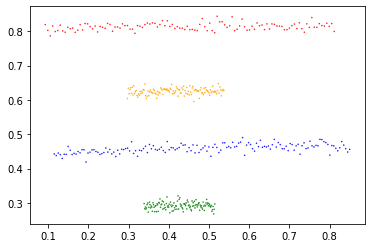

In [10]:
colors = ['blue', 'orange', 'green', 'red']
plt.scatter(X_ds[:, 0], X_ds[:, 1], s=0.25, c=y_ds, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

In [11]:
#check the clustering result with Kmeans
kmeans_ori = KMeans(n_clusters=4).fit(X_ds)
kmeans_labels_ori = kmeans_ori.labels_

normalized_mutual_info_score(kmeans_labels_ori, y_ds)

0.6725209657899904

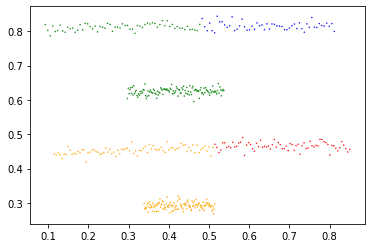

In [12]:
colors = ['blue', 'orange', 'green', 'red']
plt.scatter(X_ds[:, 0], X_ds[:, 1], s=0.25, c=kmeans_labels_ori, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

## Data Augmentation

####MixUp

In [13]:
def mixup(data):
  view = data.copy()
  for i in range(len(view)):
    random_row_index = random.randint(0, len(view)-1)
    view[i] = view[i]*0.5  + view[random_row_index]*0.5
  return view

####MixCut

In [14]:
def mixcut(data):
  data_copy = data.copy()
  view = data.copy()
  mask_len = 100

  for i in range(len(data_copy)):
    random_row_id = random.randint(0, len(data_copy)-1)
    random_column_id = random.randint(0, data_copy.shape[1]-mask_len)
    view[i,random_column_id:(random_column_id+mask_len)] = data_copy[random_row_id,random_column_id:(random_column_id+mask_len)]
  return view

#### Masking with mean

In [15]:
def get_random_indices(data, portion_of_mask):
  return np.random.choice(data.shape[1], size=np.floor(data.shape[1]*portion_of_mask).astype(int), replace=False)

In [16]:
def masking_with_mean(data, portion_of_mask):
  mean = np.mean(data, axis=0)
  column_mu = np.mean(data, axis=0)
  column_std = np.std(data, axis=0)

  view = data.copy()

  for i in range(len(data)): 
    masked_indices = get_random_indices(data, portion_of_mask)
   
    for j in range(len(mean)):
      if j in masked_indices:
        view[i,j] = column_mu[j]
              
  return view

####Masking with random value in domain range

In [17]:
def masking_with_random(data, portion_of_mask):
  mean = np.mean(data, axis=0)
  column_mu = np.mean(data, axis=0)
  column_std = np.std(data, axis=0)
  column_min = np.minimum(data)
  column_max = np.maximum(data)

  view = data.copy()

  for i in range(len(data)): 
    masked_indices = get_random_indices(data, portion_of_mask)
   
    for j in range(len(mean)):
      if j in masked_indices:
        view[i,j] = random.randint(column_min[j], column_max[j])
              
  return view

####Masking with margin distribution

In [18]:
def masking_with_margin_distribution(data, portion_of_mask):
  mean = np.mean(data, axis=0)
  column_mu = np.mean(data, axis=0)
  column_std = np.std(data, axis=0)

  view = data.copy()

  for i in range(len(data)): 
    masked_indices = get_random_indices(data, portion_of_mask)
   
    for j in range(len(mean)):
      if j in masked_indices:
        view[i,j] = np.random.normal(column_mu[j], column_std[j])
              
  return view

####Upsampling (SMOTE like)

In [19]:
#put all data points in kd-tree for fast searching
kdtree = KDTree(X_ds, leaf_size=2)

In [20]:
#get random point in the k nearest neighbors
def get_idx_random_knn(x,k):
   _, ids = kdtree.query(x.reshape(1, -1), k=k)
   ids = ids.flatten()
   ids = ids[1:-1]
   random_id = np.random.choice(ids, 1)
   return random_id

In [21]:
#mix up with a random near neighbor 
def mixup_random_neighbor(data, k):
  view = data.copy()
  for i in range(len(view)):
    point = data[i]
    random_neighbor_id = get_idx_random_knn(x=point, k=k)
    view[i] = 0.5*data[i] + 0.5*data[random_neighbor_id]
  return view

In [22]:
#a random neighbor as augmentation
def random_near_neighbor(data, k):
  view = data.copy()
  for i in range(len(view)):
    point = data[i]
    random_neighbor_id = get_idx_random_knn(x=point, k=k)
    view[i] = data[random_neighbor_id]
  return view

##Create Model and Train with Augmented Data

In [28]:
class MyDataSet(Dataset):
  def __init__(self, view1, view2):
 
    X_view1 = view1.copy()
    X_view2 = view2.copy()
    self.X_view1 = X_view1.copy().astype(np.float32)
    self.X_view2 = X_view2.copy().astype(np.float32)
  
  def __len__(self):
    return len(self.X_view1)
  
  def __getitem__(self, idx):
    return self.X_view1[idx], self.X_view2[idx]

In [24]:
# define the NN architecture
class convBackbone(nn.Module):
    def __init__(self):
        super(convBackbone, self).__init__()

        #turn on dropout for testing the 'cropping' data augmentation 
        #self.dropout = nn.Dropout(p=0.1)
        
        self.fc1 = nn.Linear(2, 2, bias=False)
        self.bn1 = nn.BatchNorm1d(2)

        self.fc2 = nn.Linear(2, 2, bias=False)
        self.bn2 = nn.BatchNorm1d(2)

        self.fc3 = nn.Linear(2, 2, bias=False)
        self.bn3 = nn.BatchNorm1d(2)


    def forward(self, x):

        #turn on dropout for testing the 'cropping' data augmentation 
        #x = self.dropout(x)
        
        #x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.bn3(self.fc3(x))
                
        return x

In [25]:
class SimSiam(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimSiamProjectionHead(2, 2, 2)
        self.prediction_head = SimSiamPredictionHead(2, 2, 2)

    def forward(self, x):
        f = self.backbone(x)
        z = f.flatten(start_dim=1)
        z = self.projection_head(z)
        p = self.prediction_head(z)
        z = z.detach()
        return f, z, p

backbone = convBackbone()
model = SimSiam(backbone)

In [26]:
criterion = NegativeCosineSimilarity()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

#cosine annealing lr
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=500, eta_min=0)

In [29]:
view1 = random_near_neighbor(X_ds, 30)
view2 = random_near_neighbor(X_ds, 30)

#turn on the following to test other augmentations

#view1 = mixup_random_neighbor(X_ds, 15)
#view2 = mixup_random_neighbor(X_ds, 15)

#view1 = mixup(X_ds)
#view2 = mixup(X_ds)

#view1 = mixcut(X_ds)
#view2 = mixcut(X_ds)

#view1 = masking_with_mean(X_ds, 0.4)
#view2 = masking_with_mean(X_ds, 0.4)

#view1 = masking_with_random(X_ds, 0.4)
#view2 = masking_with_random(X_ds, 0.4)

#view1 = masking_with_margin_distribution(X_ds, 0.4)
#view2 = masking_with_margin_distribution(X_ds, 0.4)

train_ds = MyDataSet(view1, view2)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

for epoch in range(500):
    total_loss = 0
    for x0,x1 in train_dl:
        x0 = x0.to(device)
        x1 = x1.to(device)
        _, z0, p0 = model(x0)
        _, z1, p1 = model(x1)

        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        total_loss += loss.detach()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

    avg_loss = total_loss / len(train_dl)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

epoch: 00, loss: -0.24966
epoch: 01, loss: -0.40782
epoch: 02, loss: -0.52872
epoch: 03, loss: -0.58880
epoch: 04, loss: -0.63737
epoch: 05, loss: -0.17367
epoch: 06, loss: -0.71824
epoch: 07, loss: -0.79354
epoch: 08, loss: -0.79589
epoch: 09, loss: -0.76046
epoch: 10, loss: -0.76362
epoch: 11, loss: -0.83728
epoch: 12, loss: -0.74244
epoch: 13, loss: -0.81376
epoch: 14, loss: -0.87477
epoch: 15, loss: -0.89469
epoch: 16, loss: -0.90451
epoch: 17, loss: -0.92356
epoch: 18, loss: -0.93799
epoch: 19, loss: -0.95945
epoch: 20, loss: -0.98257
epoch: 21, loss: -0.98057
epoch: 22, loss: -0.98995
epoch: 23, loss: -0.98811
epoch: 24, loss: -0.99043
epoch: 25, loss: -0.98797
epoch: 26, loss: -0.99043
epoch: 27, loss: -0.99053
epoch: 28, loss: -0.98922
epoch: 29, loss: -0.99111
epoch: 30, loss: -0.98972
epoch: 31, loss: -0.99121
epoch: 32, loss: -0.99045
epoch: 33, loss: -0.99120
epoch: 34, loss: -0.98611
epoch: 35, loss: -0.99051
epoch: 36, loss: -0.99146
epoch: 37, loss: -0.99171
epoch: 38, l

##Check the Training Result

In [31]:
ds_cl= MyDataSet(X_ds, X_ds)
dl_cl = DataLoader(ds_cl, batch_size=256)

In [32]:
embeddings = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    for dl_cl1, dl_cl2 in dl_cl:

        dl_cl1 = dl_cl1.to(device)
        f, z, p = model(dl_cl1)
        
        # store the embeddings in lists
        embeddings.append(f)

# concatenate the embeddings, targets and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

In [33]:
test = (embeddings - embeddings.mean(axis=0)) / (embeddings.std(axis=0))

In [35]:
#KMeans in latent space
kmeans_backbone = KMeans(n_clusters=4).fit(test)
kmeans_labels_backbone = kmeans_backbone.labels_

In [36]:
normalized_mutual_info_score(kmeans_labels_backbone, y_ds)

0.7950474210402625

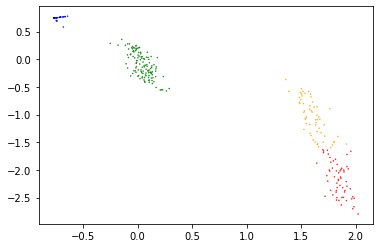

In [37]:
colors = ['blue', 'orange', 'green', 'red']
plt.scatter(test[:, 0], test[:, 1], s=0.25, c=kmeans_labels_backbone, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

In [ ]:
#NMI increases from 0.67 to 0.79